# 数据导入
> 考虑到LFW原始数据集中有很多人只有一张照片，也有部分人有上百张照片\
> 为了保持每个人对应的人脸照片量合适\
> 同时尽量减少需要分类的人的个数以减小网络大小方便训练\
> 因此本次实验最终挑选有30-100张照片的人
1. 读入图片并获取人名
2. 挑选其中30-100张照片的人
3. 定义DataSet

In [1]:
# 导入自定义包load_image
from load_image import load_image_people
import numpy as np
import matplotlib.pylab as plt

In [2]:
# 导入人脸数据，寻找每个标签样本在30-100之间的
# 并进行人脸图像预处理
image_path = ".\\lfw_home\\lfw_funneled"
data, label, name_dict = load_image_people(image_path)

In [3]:
# 查看数据
n_classes = len(name_dict)
target_names = name_dict.values()

In [4]:
# 特征选择
# F检验
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
data_p = data
data = SelectKBest(f_classif, k=7500).fit_transform(data_p, label)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.datasets import fetch_lfw_people
from sklearn.svm import SVC

In [6]:
# 数据分离
X_train, X_test, y_train, y_test = train_test_split(
    data, label, test_size=0.2, random_state=42)
# 降维维数
n_components = 175

In [7]:
# 定义SVM训练器
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
      'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)

In [8]:
# PCA降维
from sklearn.decomposition import PCA
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
clf.fit(X_train_pca, y_train)

GridSearchCV(estimator=SVC(class_weight='balanced'),
             param_grid={'C': [1000.0, 5000.0, 10000.0, 50000.0, 100000.0],
                         'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]})

In [9]:
from sklearn.metrics import accuracy_score
y_score_pca = clf.decision_function(X_test_pca)
y_pred = clf.predict(X_test_pca)
# 预测
y_accuracy_pca = accuracy_score(y_test, y_pred)
print(y_accuracy_pca)

0.6666666666666666


In [10]:
# KPCA降维
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=n_components,kernel='cosine').fit(X_train)
X_train_kpca = kpca.transform(X_train)
X_test_kpca = kpca.transform(X_test)

clf.fit(X_train_kpca, y_train)
y_score_kpca = clf.decision_function(X_test_kpca)
y_pred = clf.predict(X_test_kpca)
# 预测
y_accuracy_kpca = accuracy_score(y_test, y_pred)
print(y_accuracy_kpca)

0.7235772357723578


In [11]:
# MDS降维
from sklearn.manifold import MDS

mds = MDS(n_components = n_components).fit(X_train)

X_train_mds = mds.fit_transform(X_train)
X_test_mds = mds.fit_transform(X_test)
clf.fit(X_train_mds, y_train)
y_score_mds = clf.decision_function(X_test_mds)
y_pred = clf.predict(X_test_mds)
# 预测
y_accuracy_mds = accuracy_score(y_test, y_pred)
print(y_accuracy_mds)

0.032520325203252036


In [12]:
# LLE降维
from sklearn.manifold import LocallyLinearEmbedding 

lle = LocallyLinearEmbedding(n_components = n_components, n_neighbors = 200, neighbors_algorithm='auto').fit(X_train)

X_train_lle = lle.transform(X_train)
X_test_lle = lle.transform(X_test)

clf.fit(X_train_lle, y_train)
y_score_lle = clf.decision_function(X_test_lle)
y_pred = clf.predict(X_test_lle)
# 预测
y_accuracy_lle = accuracy_score(y_test, y_pred)
print(y_accuracy_lle)

0.6869918699186992


In [13]:
# ISOMAP 降维
from sklearn.manifold import Isomap

isomap = Isomap(n_components=n_components, n_neighbors=200, neighbors_algorithm='auto').fit(X_train)

X_train_isomap = isomap.transform(X_train)
X_test_isomap = isomap.transform(X_test)

clf.fit(X_train_isomap, y_train)
y_score_isomap = clf.decision_function(X_test_isomap)
y_pred = clf.predict(X_test_isomap)
# 预测
y_accuracy_isomap = accuracy_score(y_test, y_pred)
print(y_accuracy_isomap)

0.5203252032520326


In [14]:
def draw_accuracy(models, y_accuracy, colors): 
    plt.figure()
    plt.bar(np.arange(0, 5), y_accuracy, color = colors, label = ['%s: %0.2f'%(i,j) for i,j in zip(models, y_accuracy)])
    plt.legend(loc = 1)
    plt.ylim([0, 1.01])
    plt.xlabel("model")
    plt.ylabel("val")
    plt.title("Accuracy")
    plt.show()

In [15]:
# 绘制ROC曲线
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pylab as plt 
# 微平均ROC曲线
def draw_roc(models, y_scores, y_test, colors): 
    plt.figure()
    y_test = np.array(y_test)
    y_test = label_binarize(y_test, classes= [i for i in range(n_classes)])
    for n_i, model in enumerate(models):
        y_score = y_scores[model]
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        fpr["micro"], tpr["micro"], _ =roc_curve(y_test.ravel(), y_score.ravel())  
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        lw = 2
        plt.plot(fpr["micro"], tpr["micro"], color = colors[n_i], lw = lw, label = '%s ROC curve( area = %0.2f )' % (model, roc_auc["micro"]))
        plt.xlim([0.0, 1.05])
        plt.ylim([0.0, 1.05])
    plt.legend(loc = 4)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.show()

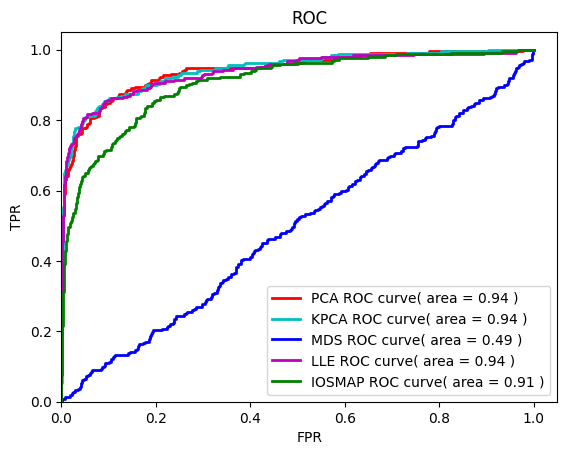

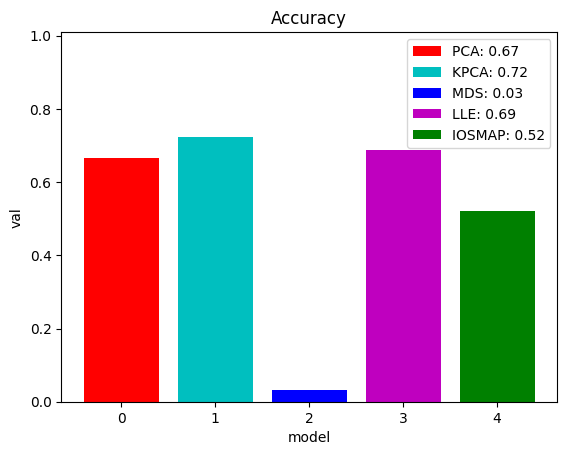

In [16]:
colors = ['r',  'c',  'b',  'm', 'g']
models = ['PCA', 'KPCA','MDS', 'LLE', 'IOSMAP']
y_scores ={
    'PCA':  y_score_pca ,
    'KPCA': y_score_kpca, 
    'MDS' : y_score_mds,
    'LLE': y_score_lle, 
    'IOSMAP': y_score_isomap
}
y_accuracy = [y_accuracy_pca, y_accuracy_kpca, y_accuracy_mds, y_accuracy_lle, y_accuracy_isomap]
draw_roc(models, y_scores, y_test, colors)
draw_accuracy(models, y_accuracy, colors)